# Forcasting H0 constraints
This notebook is meant to forecast future constraints with improved velocity dispersion measurements and larger sample sizes (including IFU data set).


In [106]:
import numpy as np
import corner
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Plots import plot_util
from hierarc.Likelihood.anisotropy_scaling import AnisotropyScalingIFU
from lenstronomy.Util import constants as const
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# matplotlib configs
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

## Model setting
Here we define the cosmological model and the population parameters to be constrainted in the hierarchical analysis.

In [23]:
cosmology = 'FLCDM'
kwargs_cosmo_true = {'h0': 70, 'om': 0.3}

anisotropy_model = 'OM'
anisotropy_distribution = 'NONE'
kwargs_kin_true = {'a_ani': 1.}
if anisotropy_distribution == 'GAUSSIAN':
    kwargs_kin_true['a_ani_sigma'] = 0.5

lambda_mst_distribution = 'delta'
kwargs_lens_true = {'lambda_mst': 1}
if lambda_mst_distribution == 'GAUSSIAN':
    kwargs_lens_true['lambda_mst_sigma'] = 0.03

# create astropy.cosmology instance of input cosmology

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)


n_walkers = 100
n_run = 500
n_burn = 200

kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': 1, 'lambda_mst_sigma': 0.03},
                     'kwargs_kin': {'a_ani': 1, 'a_ani_sigma': 0.5}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.05},
                     'kwargs_lens': {'lambda_mst': 0.1, 'lambda_mst_sigma': 0.03},
                     'kwargs_kin': {'a_ani': 0.5, 'a_ani_sigma': 0.5}}


kwargs_bounds = {'kwargs_lower_cosmo': {'h0': 0, 'om': 0},
                'kwargs_lower_lens': {'lambda_mst': 0.5, 'lambda_mst_sigma': 0},
                'kwargs_lower_kin': {'a_ani': 0.5, 'a_ani_sigma': 0},
                'kwargs_upper_cosmo': {'h0': 200, 'om': 1},
                'kwargs_upper_lens': {'lambda_mst': 1.5, 'lambda_mst_sigma': 0.5},
                'kwargs_upper_kin': {'a_ani': 5, 'a_ani_sigma': 1},
                'kwargs_fixed_cosmo': {},
                'kwargs_fixed_lens': {},
                'kwargs_fixed_kin': {}}


class CustomPrior(object):
    def __init__(self, om_prior=True, log_scatter=False):
        self._om_prior = om_prior
        self._log_scatter = log_scatter
        self.om_mean = kwargs_cosmo_true['om']
        self.sigma_om = 0.022
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin)
    
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin):

        logL = 0
        # a prior on Omega_m helps in constraining the MST parameter as the kinematics becomes less cosmology dependent...
        if self._om_prior is True:
            om = kwargs_cosmo.get('om', self.om_mean)
            logL += -(om - self.om_mean)**2 / self.sigma_om**2 / 2
            
        a_ani = kwargs_kin.get('a_ani', 1)
        logL += np.log(1/a_ani)
        return logL

### lens model
Here we define Einstein radius, power-law slope and half light radius of the deflector - and their uncertainties. In this forecast, for simplicity, we assume that all lenses are identical in these parameters to re-utilize the dimensionless kinematics prediction for all lenses.

In [3]:
# lens and light model parameters and uncertainties (used for kinematic modeling uncertainties)
theta_E, theta_E_error = 1.0, 0.02
gamma, gamma_error = 2.0, 0.03
r_eff, r_eff_error = 1.0, 0.05

## measurement uncertainties
Here we set the relative measurement uncertainties of the kinematics

In [25]:
sigma_v_measurement_sigma_rel_ground_based = 0.05  # uncertainty in the measurement of the velocity dispersion (fully covariant for IFU data)
sigma_v_measurement_sigma_rel_jwst = 0.03  # JWST-like precision on velocity dispersion 
sigma_v_measurement_sigma_indepentent = 0.01

r_bins_oifu = np.linspace(0, 2*r_eff, 4)  # radial bins in arc seconds of the OIFU data
r_bins_aoifu = np.linspace(0, 1*r_eff, 11)  # radial bins in arc seconds of the AOIFU data
r_bins_jifu = np.linspace(0, 2*r_eff, 11)  # radial bins in arc seconds of the JWST IFU data
r_bins_elt = np.linspace(0, 3*r_eff, 31)  # radial bins in arc seconds of the JWST IFU data

kwargs_seeing_single_aperture = {'psf_type': 'GAUSSIAN', 'fwhm': 0.8}
kwargs_seeing_oifu = {'psf_type': 'GAUSSIAN', 'fwhm': 0.8}
kwargs_seeing_aoifu = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1}
kwargs_seeing_jifu = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1}
kwargs_seeing_elt = {'psf_type': 'GAUSSIAN', 'fwhm': 0.02}

kwargs_single_aperture = {'aperture_type': 'slit', 'width': 1, 'length': 1, 'angle': 0, 'center_dec': 0, 'center_ra': 0}
# IFU kinematics setting

kwargs_oifu_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins_oifu, 'center_dec': 0, 'center_ra': 0}
kwargs_aoifu_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins_aoifu, 'center_dec': 0, 'center_ra': 0}
kwargs_jifu_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins_jifu, 'center_dec': 0, 'center_ra': 0}
kwargs_elt_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins_elt, 'center_dec': 0, 'center_ra': 0}

print(r_bins_elt)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]


### kinematic modeling
Here we compute the dimensionless kinematics predictions (applicable for all lenses at different redshift configurations for this forecast).

In [5]:

kwargs_numerics_galkin = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                          'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

from hierarc.LensPosterior.kin_constraints import KinConstraints
z_lens_temp, z_source_temp, sigma_v_temp, sigma_v_error_independent_temp, sigma_v_error_covariant_temp = 0.5, 1., [1], 1, 0

kin_aperture = KinConstraints(z_lens_temp, z_source_temp, theta_E, theta_E_error, gamma, gamma_error, r_eff, r_eff_error, sigma_v_temp,
                 sigma_v_error_independent_temp, sigma_v_error_covariant_temp, kwargs_single_aperture, kwargs_seeing_single_aperture, kwargs_numerics_galkin, anisotropy_model,
                 kwargs_lens_light=None, lens_light_model_list=['HERNQUIST'], MGE_light=False, kwargs_mge_light=None,
                 hernquist_approx=True, sampling_number=1000, num_psf_sampling=100, num_kin_sampling=1000,
                 multi_observations=False)
ani_param_array = kin_aperture.ani_param_array
j_model_list_aperture, error_cov_j_sqrt_aperture = kin_aperture.model_marginalization(num_sample_model=100)
error_cov_j_sqrt_aperture = [[error_cov_j_sqrt_aperture]]
ani_scaling_array_list_aperture = kin_aperture.anisotropy_scaling()
anisotropyScalingAperture = AnisotropyScalingIFU(anisotropy_model, ani_param_array=ani_param_array, ani_scaling_array_list=ani_scaling_array_list_aperture)



#OIFU
sigma_v_temp_ifu = np.ones(len(r_bins_oifu) - 1)
kin_oifu = KinConstraints(z_lens_temp, z_source_temp, theta_E, theta_E_error, gamma, gamma_error, r_eff, r_eff_error, sigma_v_temp_ifu,
                 sigma_v_error_independent_temp, sigma_v_error_covariant_temp, kwargs_oifu_aperture, kwargs_seeing_oifu, kwargs_numerics_galkin, anisotropy_model,
                 kwargs_lens_light=None, lens_light_model_list=['HERNQUIST'], MGE_light=False, kwargs_mge_light=None,
                 hernquist_approx=True, sampling_number=1000, num_psf_sampling=100, num_kin_sampling=1000,
                 multi_observations=False)


j_model_list_oifu, error_cov_j_sqrt_oifu = kin_oifu.model_marginalization(num_sample_model=200)
ani_scaling_array_list_oifu = kin_oifu.anisotropy_scaling()
anisotropyScaling_oifu = AnisotropyScalingIFU(anisotropy_model, ani_param_array=ani_param_array, ani_scaling_array_list=ani_scaling_array_list_oifu)

#AOIFU
sigma_v_temp_ifu = np.ones(len(r_bins_aoifu) - 1)
kin_aoifu = KinConstraints(z_lens_temp, z_source_temp, theta_E, theta_E_error, gamma, gamma_error, r_eff, r_eff_error, sigma_v_temp_ifu,
                 sigma_v_error_independent_temp, sigma_v_error_covariant_temp, kwargs_aoifu_aperture, kwargs_seeing_aoifu, kwargs_numerics_galkin, anisotropy_model,
                 kwargs_lens_light=None, lens_light_model_list=['HERNQUIST'], MGE_light=False, kwargs_mge_light=None,
                 hernquist_approx=True, sampling_number=1000, num_psf_sampling=100, num_kin_sampling=1000,
                 multi_observations=False)


j_model_list_aoifu, error_cov_j_sqrt_aoifu = kin_aoifu.model_marginalization(num_sample_model=200)
ani_scaling_array_list_aoifu = kin_aoifu.anisotropy_scaling()
anisotropyScaling_aoifu = AnisotropyScalingIFU(anisotropy_model, ani_param_array=ani_param_array, ani_scaling_array_list=ani_scaling_array_list_aoifu)


#JWST IFU
sigma_v_temp_ifu = np.ones(len(r_bins_jifu) - 1)
kin_jifu = KinConstraints(z_lens_temp, z_source_temp, theta_E, theta_E_error, gamma, gamma_error, r_eff, r_eff_error, sigma_v_temp_ifu,
                 sigma_v_error_independent_temp, sigma_v_error_covariant_temp, kwargs_jifu_aperture, kwargs_seeing_jifu, kwargs_numerics_galkin, anisotropy_model,
                 kwargs_lens_light=None, lens_light_model_list=['HERNQUIST'], MGE_light=False, kwargs_mge_light=None,
                 hernquist_approx=True, sampling_number=2000, num_psf_sampling=200, num_kin_sampling=2000,
                 multi_observations=False)


j_model_list_jifu, error_cov_j_sqrt_jifu = kin_jifu.model_marginalization(num_sample_model=500)
ani_scaling_array_list_jifu = kin_jifu.anisotropy_scaling()
anisotropyScaling_jifu = AnisotropyScalingIFU(anisotropy_model, ani_param_array=ani_param_array, ani_scaling_array_list=ani_scaling_array_list_jifu)


#ELT IFU
sigma_v_temp_ifu = np.ones(len(r_bins_elt) - 1)
kin_elt = KinConstraints(z_lens_temp, z_source_temp, theta_E, theta_E_error, gamma, gamma_error, r_eff, r_eff_error, sigma_v_temp_ifu,
                 sigma_v_error_independent_temp, sigma_v_error_covariant_temp, kwargs_elt_aperture, kwargs_seeing_elt, kwargs_numerics_galkin, anisotropy_model,
                 kwargs_lens_light=None, lens_light_model_list=['HERNQUIST'], MGE_light=False, kwargs_mge_light=None,
                 hernquist_approx=True, sampling_number=5000, num_psf_sampling=200, num_kin_sampling=5000,
                 multi_observations=False)


j_model_list_elt, error_cov_j_sqrt_elt = kin_elt.model_marginalization(num_sample_model=500)
ani_scaling_array_list_elt = kin_elt.anisotropy_scaling()
anisotropyScaling_elt = AnisotropyScalingIFU(anisotropy_model, ani_param_array=ani_param_array, ani_scaling_array_list=ani_scaling_array_list_elt)


## Draw lens sample
Here we draw a single lens with its measurements according to the specified uncertainty and underlying model distribution and set up the likelihood for the hierarchical analysis

In [26]:


def likelihood_lens(z_lens, z_source, sigma_v_measurement_sigma_rel, sigma_v_measurement_sigma_indepentent, ddt_sigma_rel=None, kin_type='aperture', no_noise=True):
    """
    """   
    
    lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo_true)
    ds_dds = lensCosmo.ds / lensCosmo.dds
    
    if kin_type == 'aperture':
        j_model = j_model_list_aperture
        error_cov_j_sqrt = error_cov_j_sqrt_aperture
        ani_scaling_array_list = ani_scaling_array_list_aperture
        anisotropyScaling = anisotropyScalingAperture
    elif kin_type == 'OIFU':
        j_model = j_model_list_oifu
        error_cov_j_sqrt = error_cov_j_sqrt_oifu
        ani_scaling_array_list = ani_scaling_array_list_oifu
        anisotropyScaling = anisotropyScaling_oifu
    elif kin_type == 'AOIFU':
        j_model = j_model_list_aoifu
        error_cov_j_sqrt = error_cov_j_sqrt_aoifu
        ani_scaling_array_list = ani_scaling_array_list_aoifu
        anisotropyScaling = anisotropyScaling_aoifu
    elif kin_type == 'JIFU':
        j_model = j_model_list_jifu
        error_cov_j_sqrt = error_cov_j_sqrt_jifu
        ani_scaling_array_list = ani_scaling_array_list_jifu
        anisotropyScaling = anisotropyScaling_jifu
    elif kin_type == 'ELT':
        j_model = j_model_list_elt
        error_cov_j_sqrt = error_cov_j_sqrt_elt
        ani_scaling_array_list = ani_scaling_array_list_elt
        anisotropyScaling = anisotropyScaling_elt
    # include anisotropy (draw from)
    aniso_param_array = anisotropyScaling.draw_anisotropy(**kwargs_kin_true)
    aniso_scaling = anisotropyScaling.ani_scaling(aniso_param_array)

    lambda_int = np.random.normal(kwargs_lens_true['lambda_mst'], kwargs_lens_true.get('lambda_mst_sigma', 0))
    # calculate scaling with anisotropy and lambda_int
    
    # predict velocity dispersion from j_model
    sigma_v_true = np.sqrt(j_model * ds_dds * aniso_scaling * lambda_int) * const.c / 1000

    # draw measurement
    error_cov_measurement = np.outer(sigma_v_true, sigma_v_true) * sigma_v_measurement_sigma_rel**2
    error_cov_measurement += np.diag((sigma_v_true * sigma_v_measurement_sigma_indepentent)**2)

    if no_noise is True:
        sigma_v_measurement = sigma_v_true
    else:    
        sigma_v_measurement = np.random.multivariate_normal(sigma_v_true, error_cov_measurement) 
    
    # predict j_model (draw from origina true prediction based on covariant errors)
    if no_noise is True:
        j_model_draw = j_model
    else:
        j_model_draw = np.random.multivariate_normal(np.sqrt(j_model), error_cov_j_sqrt)**2

    kwargs_likelihood = {'z_lens': z_lens, 
                         'z_source': z_source, 
                         'likelihood_type': 'IFUKinCov',
                         'sigma_v_measurement': sigma_v_measurement, 'anisotropy_model': anisotropy_model,
                         'j_model': j_model_draw,  'error_cov_measurement': error_cov_measurement,
                         'error_cov_j_sqrt': error_cov_j_sqrt, 'ani_param_array': ani_param_array,
                         'ani_scaling_array_list': ani_scaling_array_list}
    
    # predict ddt and draw from uncertainties
    if ddt_sigma_rel is not None:
        ddt_true = lensCosmo.ddt
        ddt_sigma = ddt_true * ddt_sigma_rel
        if no_noise is True:
            ddt_mean = ddt_true
        else:
            ddt_mean = np.random.normal(ddt_true, ddt_sigma)
        kwargs_likelihood['likelihood_type'] = 'DdtGaussKin'
        kwargs_likelihood['ddt_mean'] = ddt_mean
        kwargs_likelihood['ddt_sigma'] = ddt_sigma
    return kwargs_likelihood


## TDCOSMO sample
Here we generate a TDCOSMO-like sample

In [34]:
tdcosmo_list = [{'z_lens': 0.6304, 'z_source': 1.394, 'ddt_sigma_rel': 0.051},  # B1608+656
                {'z_lens': 0.295, 'z_source': 0.654, 'ddt_sigma_rel': 0.043},  # RXJ1131-1231
                {'z_lens': 0.4546, 'z_source': 1.693, 'ddt_sigma_rel': 0.065},  # HE0435-1223
                {'z_lens': 0.745, 'z_source': 1.789, 'ddt_sigma_rel': 0.091},  # SDSS1206+4332
                {'z_lens': 0.6575, 'z_source': 1.662, 'ddt_sigma_rel': 0.067},  # WFI2033-4723
                {'z_lens': 0.311, 'z_source': 1.722, 'ddt_sigma_rel': 0.090},  # PG1115+080
                {'z_lens': 0.597, 'z_source': 2.375, 'ddt_sigma_rel': 0.039},  # DES0408-5354
               ]

tdcosmo_likelihood_aperture = []
tdcosmo_likelihood_ifu = []
tdcosmo_likelihood_aoifu = []
tdcosmo_likelihood_jwst = []
tdcosmo_likelihood_elt = []

for lens in tdcosmo_list:
    tdcosmo_likelihood_aperture.append(likelihood_lens(kin_type='aperture', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_ground_based, sigma_v_measurement_sigma_indepentent=0, **lens))
    tdcosmo_likelihood_ifu.append(likelihood_lens(kin_type='OIFU', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_ground_based, sigma_v_measurement_sigma_indepentent=0, **lens))
    tdcosmo_likelihood_aoifu.append(likelihood_lens(kin_type='AOIFU', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_ground_based, sigma_v_measurement_sigma_indepentent=sigma_v_measurement_sigma_indepentent, **lens))
    tdcosmo_likelihood_jwst.append(likelihood_lens(kin_type='JIFU', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_jwst, sigma_v_measurement_sigma_indepentent=sigma_v_measurement_sigma_indepentent, **lens))
    tdcosmo_likelihood_elt.append(likelihood_lens(kin_type='ELT', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_jwst, sigma_v_measurement_sigma_indepentent=sigma_v_measurement_sigma_indepentent, **lens))
    
    



## TDCOSMO hierarchical inference only
Here we sample the forecast of a TDCOSMO-like sample. The goal is to reproduce the precision achived in Birrer et al. 2020.


100%|██████████| 700/700 [07:12<00:00,  1.68it/s]


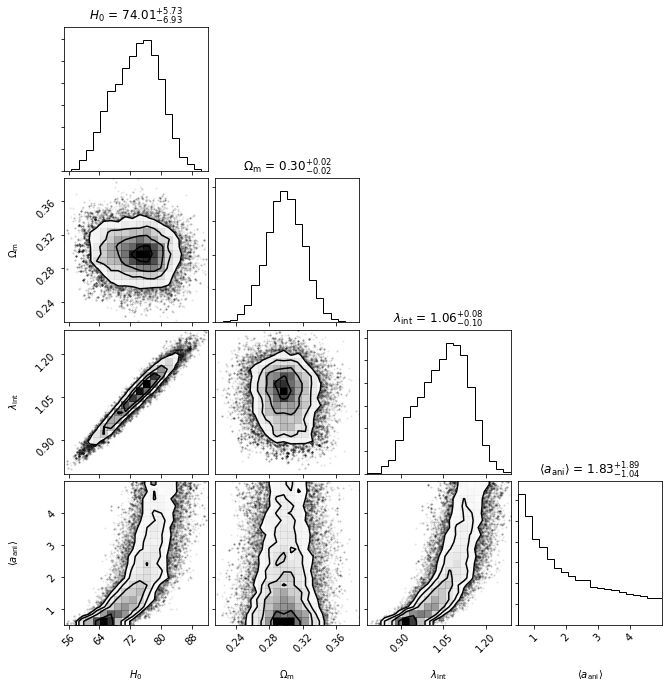

In [35]:
# aperture velocity dispersion

mcmc_sampler_tdcosmo_aperture = MCMCSampler(tdcosmo_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aperture, log_prob_cosmo_tdcosmo_aperture = mcmc_sampler_tdcosmo_aperture.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aperture, show_titles=True, labels=mcmc_sampler_tdcosmo_aperture.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [10:54<00:00,  1.05s/it]


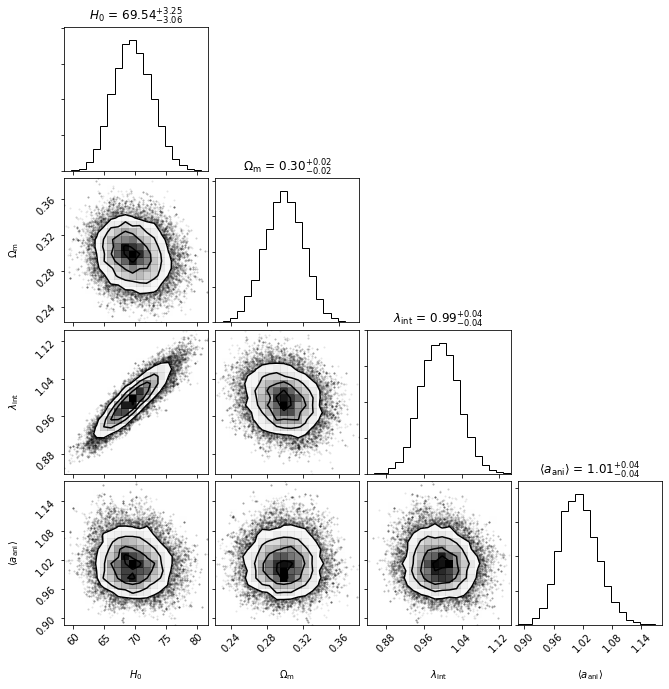

In [36]:
# IFU velocity dispersion for ground based telescopes

mcmc_sampler_tdcosmo_ifu = MCMCSampler(tdcosmo_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_ifu, log_prob_cosmo_tdcosmo_ifu = mcmc_sampler_tdcosmo_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_ifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [16:49<00:00,  1.35s/it]


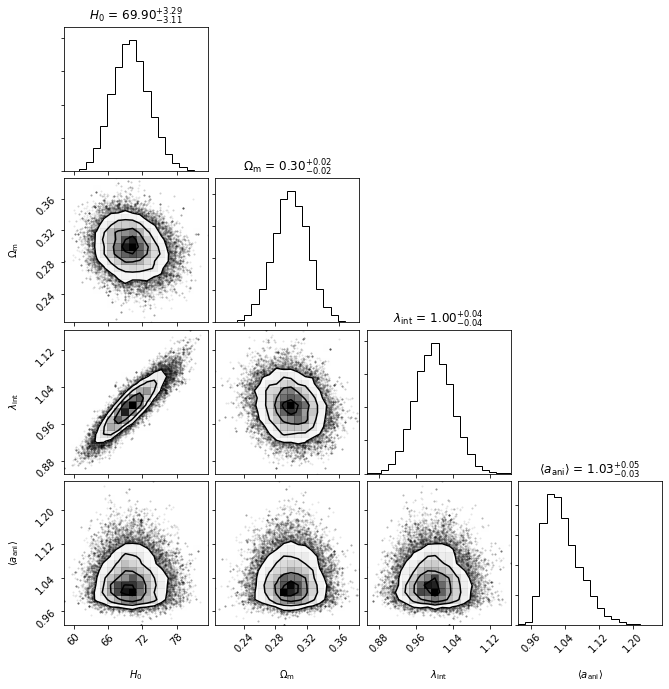

In [37]:
# IFU velocity dispersion for AO ground based telescopes

mcmc_sampler_tdcosmo_aoifu = MCMCSampler(tdcosmo_likelihood_aoifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aoifu, log_prob_cosmo_tdcosmo_aoifu = mcmc_sampler_tdcosmo_aoifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aoifu, show_titles=True, labels=mcmc_sampler_tdcosmo_aoifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [15:20<00:00,  1.30s/it]


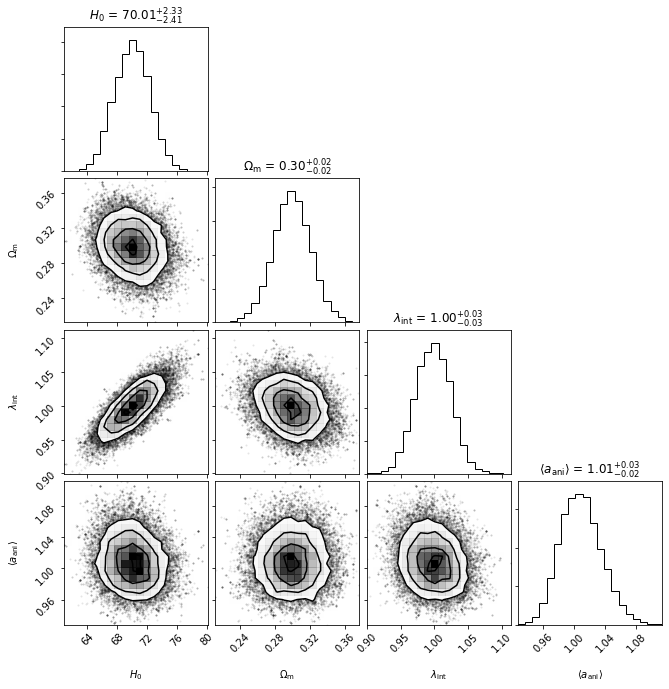

In [38]:
# JWST-like forecast for all 7 TDCOSMO lenses

mcmc_sampler_tdcosmo_jwst = MCMCSampler(tdcosmo_likelihood_jwst, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_jwst, log_prob_cosmo_tdcosmo_jwst = mcmc_sampler_tdcosmo_jwst.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_jwst, show_titles=True, labels=mcmc_sampler_tdcosmo_jwst.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [25:59<00:00,  2.37s/it]


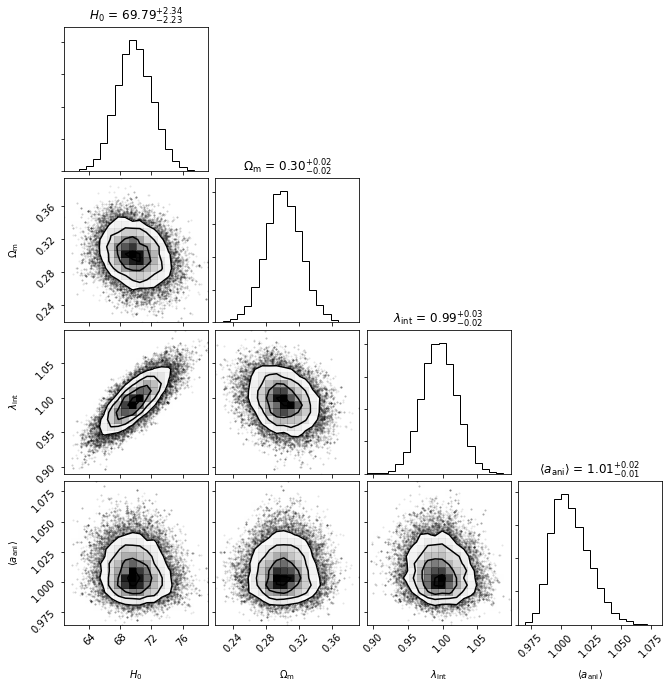

In [39]:
# ELT-like forecast for all 7 TDCOSMO lenses

mcmc_sampler_tdcosmo_elt = MCMCSampler(tdcosmo_likelihood_elt, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_elt, log_prob_cosmo_tdcosmo_elt = mcmc_sampler_tdcosmo_elt.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_elt, show_titles=True, labels=mcmc_sampler_tdcosmo_elt.param_names(latex_style=True))
plt.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:95: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


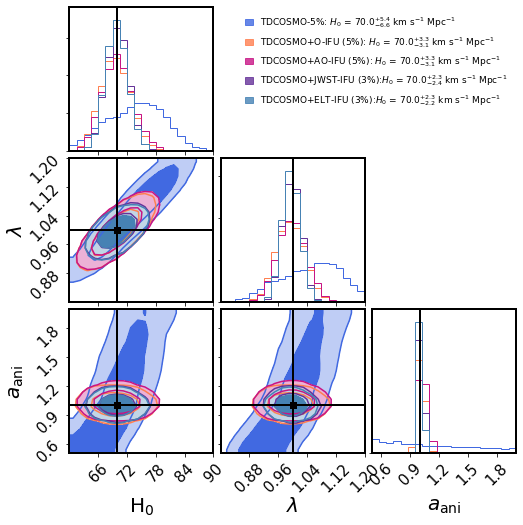

In [108]:
def select_params(mcmc_samples, param_indexes):
    """
    selects a subset of the parameters to be plotted
    """
    
    keep_list = []
    for i in param_indexes:
        keep_list.append(i)
    mcmc_samples_select = copy.deepcopy(mcmc_samples.T[keep_list].T)
    return mcmc_samples_select

truths = mcmc_sampler_tdcosmo_jwst.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_kin=kwargs_kin_true)
labels = mcmc_sampler_tdcosmo_jwst.param_names(latex_style=True)

with_omega_m = False

if with_omega_m is True:
    param_indexes_select = [0, 1, 2, 3]
    extents = [[60, 90], [0.2, 0.4], [0.8, 1.2], [0.5, 2]]
    labels_select = [r'H$_0$', r'$\Omega_{\rm m}$', r'$\lambda$', r'$a_{\rm ani}$']
else:
    param_indexes_select = [0, 2, 3]
    extents = [[60, 90], [0.8, 1.2], [0.5, 2]]
    labels_select = [r'H$_0$', r'$\lambda$', r'$a_{\rm ani}$']

#labels_select = []
truths_select = []
for i in param_indexes_select:
    #labels_select.append(labels[i])
    truths_select.append(truths[i])

color_list = ['royalblue', 'coral', 'mediumvioletred', 'rebeccapurple', 'steelblue', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
levels = [0.68,0.95]
alpha = 0.8



kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                 'levels': levels, 'truths': truths_select, 'truth_color': 'k',
                 'fill_contours': True, 'plot_datapoints': False,
                 'range': extents}

mcmc_samples_tdcosmo_aperture_select = select_params(mcmc_samples_tdcosmo_aperture, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_aperture_select,
                    labels=labels_select,
                    color=color_list[0],
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    contourf_kwargs={'color': color_list[0]},
                    **kwargs_corner
                   )
mcmc_samples_tdcosmo_ifu_select = select_params(mcmc_samples_tdcosmo_ifu, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_ifu_select, color=color_list[1], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[1]}, **kwargs_corner)

mcmc_samples_tdcosmo_aoifu_select = select_params(mcmc_samples_tdcosmo_aoifu, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_aoifu_select, color=color_list[2], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[2]}, **kwargs_corner)

mcmc_samples_tdcosmo_jwst_select = select_params(mcmc_samples_tdcosmo_jwst, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_jwst_select, color=color_list[3], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[3]}, **kwargs_corner)

mcmc_samples_tdcosmo_elt_select = select_params(mcmc_samples_tdcosmo_elt, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_elt_select, color=color_list[4], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[4]}, **kwargs_corner)



ax = fig.axes[2]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_tdcosmo_aperture = plot_util.result_string(mcmc_samples_tdcosmo_aperture[:,0]/np.median(mcmc_samples_tdcosmo_aperture[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_ifu = plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,0]/np.median(mcmc_samples_tdcosmo_ifu[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_aoifu = plot_util.result_string(mcmc_samples_tdcosmo_aoifu[:,0]/np.median(mcmc_samples_tdcosmo_aoifu[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_jwst = plot_util.result_string(mcmc_samples_tdcosmo_jwst[:,0]/np.median(mcmc_samples_tdcosmo_jwst[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_elt = plot_util.result_string(mcmc_samples_tdcosmo_elt[:,0]/np.median(mcmc_samples_tdcosmo_elt[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')




patch_1 = mpatches.Patch(color=color_list[0], label='TDCOSMO-5%: ' + result_string_tdcosmo_aperture +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_2 = mpatches.Patch(color=color_list[1], label='TDCOSMO+O-IFU (5%): ' + result_string_tdcosmo_ifu +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_3 = mpatches.Patch(color=color_list[2], label='TDCOSMO+AO-IFU (5%): ' + result_string_tdcosmo_aoifu +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_4 = mpatches.Patch(color=color_list[3], label='TDCOSMO+JWST-IFU (3%):' + result_string_tdcosmo_jwst +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_5 = mpatches.Patch(color=color_list[4], label='TDCOSMO+ELT-IFU (3%):' + result_string_tdcosmo_elt +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)



ax.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], fontsize=9, handlelength=0.9, loc=1, frameon=False)
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/Forecast/tdcosmo_only_forecast.pdf')
fig.show()


# remove omega_m

## Add external lensing sample
We add 50 lenses with single aperture kinematics of 5% precision

In [42]:
num_external_lenses = 50

kin_likelihood_aperture = []
kin_likelihood_ifu = []

for i in range(num_external_lenses):
    z_lens = np.random.uniform(low=0.1, high=0.6)
    z_source = np.random.uniform(low=z_lens+0.2, high=3)
    kin_likelihood_aperture.append(likelihood_lens(z_lens=z_lens, z_source=z_source, kin_type='aperture', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_ground_based, sigma_v_measurement_sigma_indepentent=0))
    kin_likelihood_ifu.append(likelihood_lens(z_lens=z_lens, z_source=z_source, kin_type='OIFU', sigma_v_measurement_sigma_rel=sigma_v_measurement_sigma_rel_ground_based, sigma_v_measurement_sigma_indepentent=0))
    


100%|██████████| 700/700 [30:06<00:00,  2.53s/it]


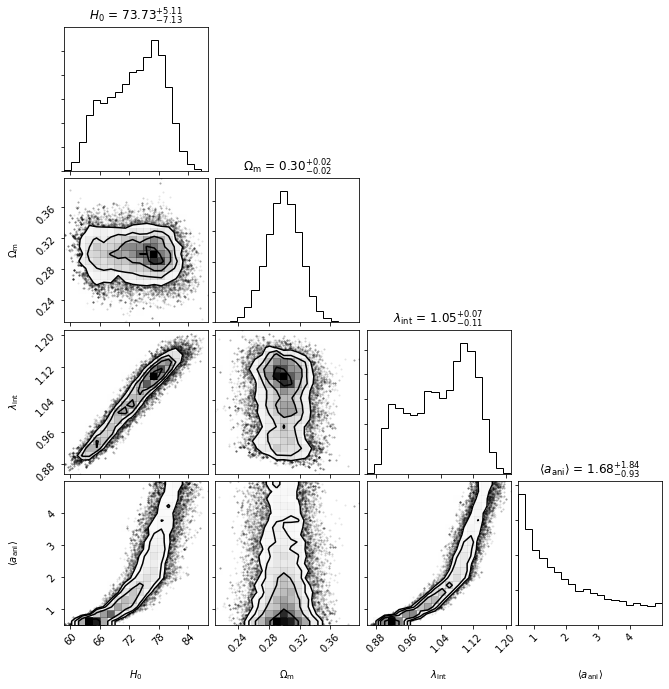

100%|██████████| 700/700 [46:44<00:00,  3.64s/it]


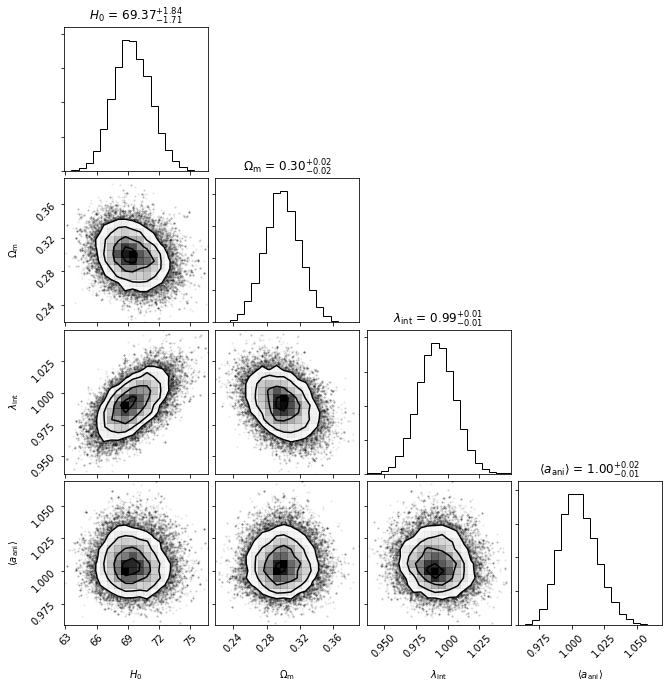

In [43]:
# aperture velocity dispersion + external

mcmc_sampler_tdcosmo_aperture_ext = MCMCSampler(tdcosmo_likelihood_aperture+kin_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aperture_ext, log_prob_cosmo_tdcosmo_aperture_ext = mcmc_sampler_tdcosmo_aperture_ext.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aperture_ext, show_titles=True, labels=mcmc_sampler_tdcosmo_aperture_ext.param_names(latex_style=True))
plt.show()

mcmc_sampler_tdcosmo_aperture_ext_ifu = MCMCSampler(tdcosmo_likelihood_aperture+kin_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aperture_ext_ifu, log_prob_cosmo_tdcosmo_aperture_ext_ifu = mcmc_sampler_tdcosmo_aperture_ext_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aperture_ext_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_aperture_ext_ifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [40:33<00:00,  3.40s/it]


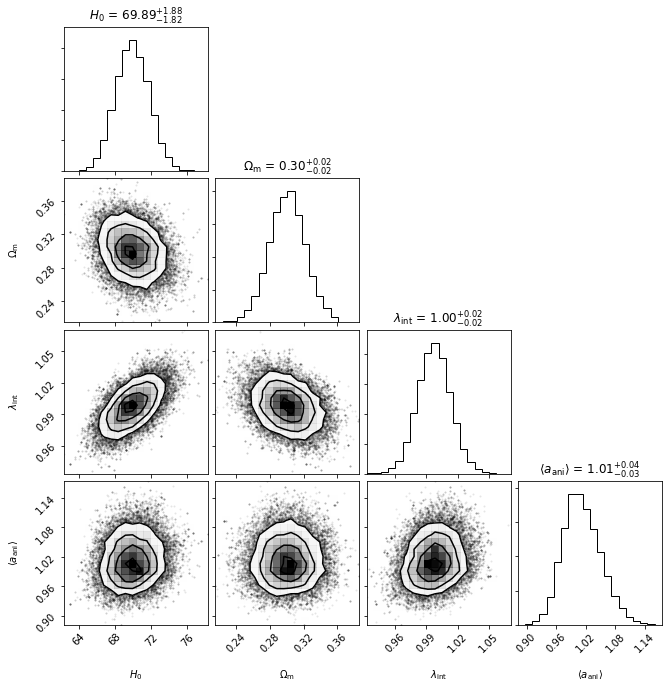

100%|██████████| 700/700 [45:54<00:00,  4.91s/it]


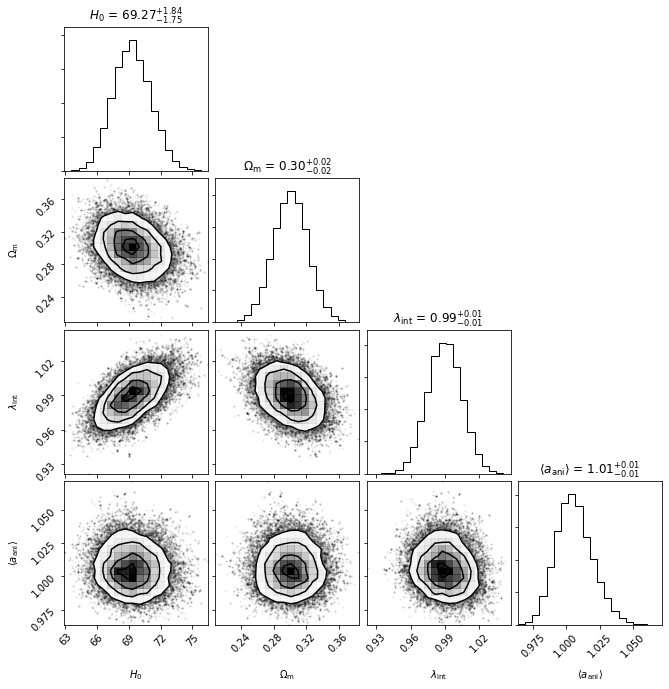

In [44]:
# IFU velocity dispersion + external

mcmc_sampler_tdcosmo_ifu_ext = MCMCSampler(tdcosmo_likelihood_ifu+kin_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_ifu_ext, log_prob_cosmo_tdcosmo_ifu_ext = mcmc_sampler_tdcosmo_ifu_ext.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_ifu_ext, show_titles=True, labels=mcmc_sampler_tdcosmo_ifu_ext.param_names(latex_style=True))
plt.show()

mcmc_sampler_tdcosmo_ifu_ext_ifu = MCMCSampler(tdcosmo_likelihood_ifu+kin_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_ifu_ext_ifu, log_prob_cosmo_tdcosmo_ifu_ext_ifu = mcmc_sampler_tdcosmo_ifu_ext_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_ifu_ext_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_ifu_ext_ifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [1:04:06<00:00,  6.21s/it]


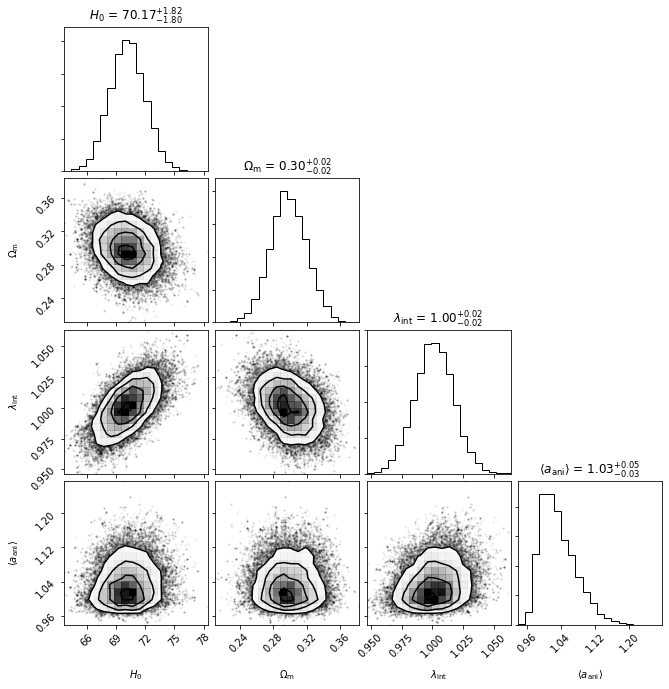

100%|██████████| 700/700 [1:07:33<00:00,  5.63s/it]


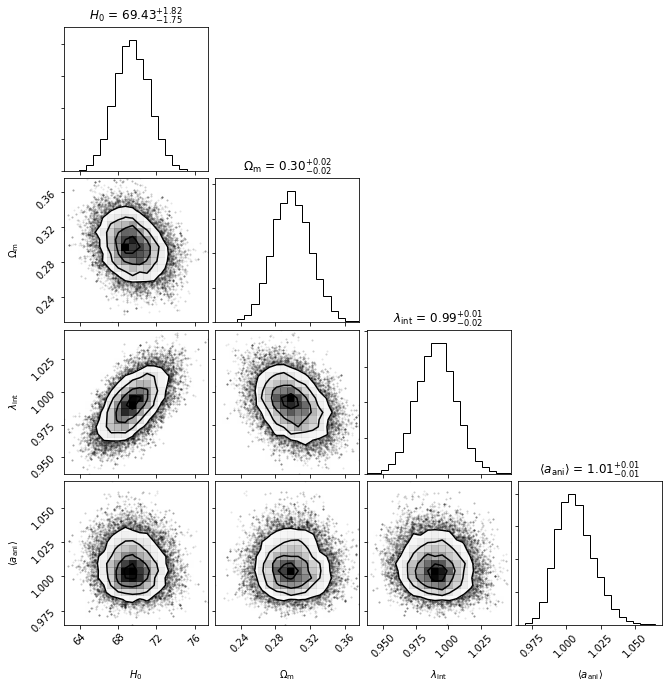

In [45]:
# AO IFU velocity dispersion + external

mcmc_sampler_tdcosmo_aoifu_ext = MCMCSampler(tdcosmo_likelihood_aoifu+kin_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aoifu_ext, log_prob_cosmo_tdcosmo_aoifu_ext = mcmc_sampler_tdcosmo_aoifu_ext.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aoifu_ext, show_titles=True, labels=mcmc_sampler_tdcosmo_aoifu_ext.param_names(latex_style=True))
plt.show()

mcmc_sampler_tdcosmo_aoifu_ext_ifu = MCMCSampler(tdcosmo_likelihood_aoifu+kin_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_aoifu_ext_ifu, log_prob_cosmo_tdcosmo_aoifu_ext_ifu = mcmc_sampler_tdcosmo_aoifu_ext_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_aoifu_ext_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_aoifu_ext_ifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [1:02:39<00:00,  5.29s/it]


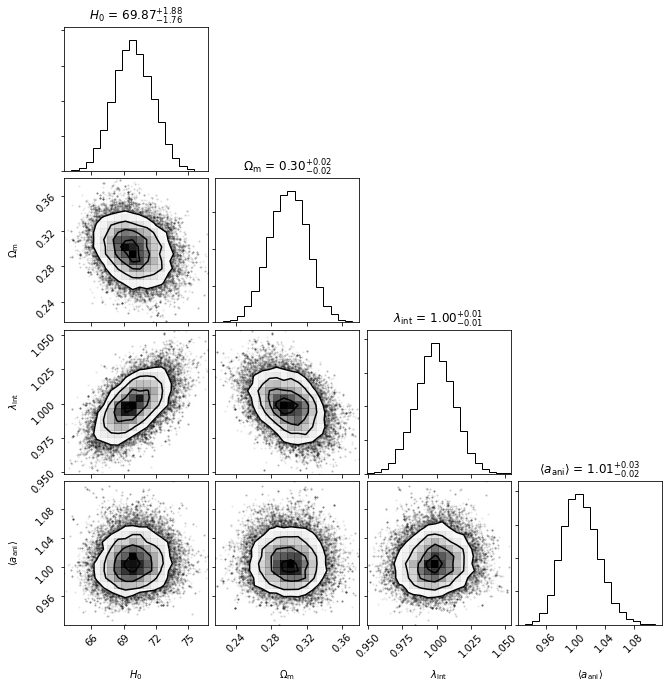

100%|██████████| 700/700 [1:04:50<00:00,  5.47s/it]


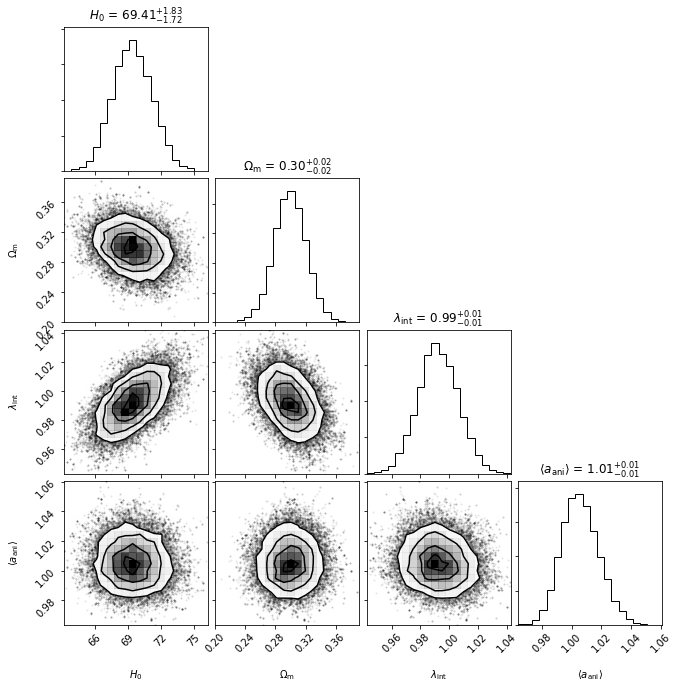

In [46]:
# JWST velocity dispersion + external

mcmc_sampler_tdcosmo_jwst_ext = MCMCSampler(tdcosmo_likelihood_jwst+kin_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_jwst_ext, log_prob_cosmo_tdcosmo_jwst_ext = mcmc_sampler_tdcosmo_jwst_ext.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_jwst_ext, show_titles=True, labels=mcmc_sampler_tdcosmo_jwst_ext.param_names(latex_style=True))
plt.show()

mcmc_sampler_tdcosmo_jwst_ext_ifu = MCMCSampler(tdcosmo_likelihood_jwst+kin_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_jwst_ext_ifu, log_prob_cosmo_tdcosmo_jwst_ext_ifu = mcmc_sampler_tdcosmo_jwst_ext_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_jwst_ext_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_jwst_ext_ifu.param_names(latex_style=True))
plt.show()

100%|██████████| 700/700 [1:08:58<00:00,  5.88s/it]


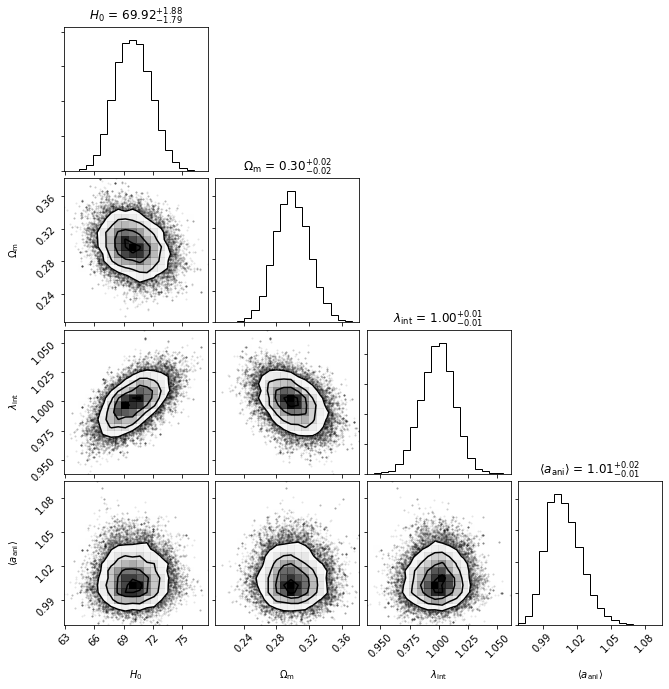

100%|██████████| 700/700 [1:18:53<00:00,  6.24s/it]


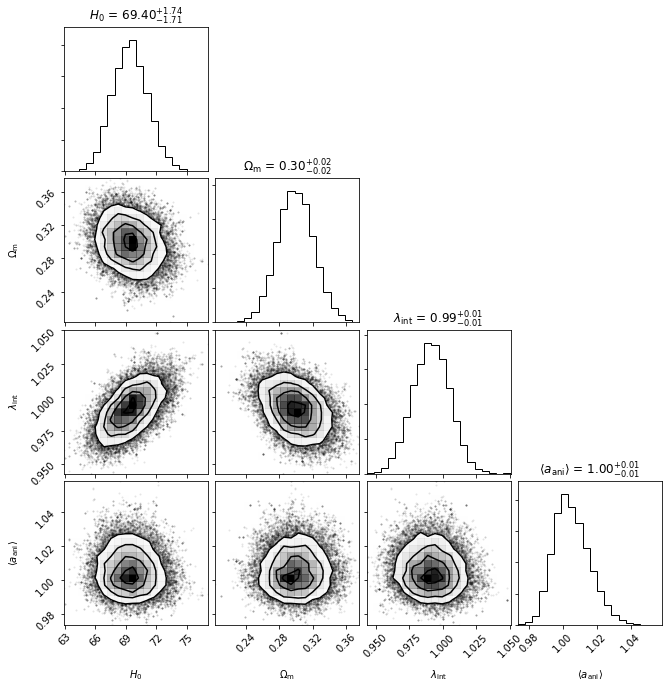

In [47]:
# ELT velocity dispersion + external

mcmc_sampler_tdcosmo_elt_ext = MCMCSampler(tdcosmo_likelihood_elt+kin_likelihood_aperture, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_elt_ext, log_prob_cosmo_tdcosmo_elt_ext = mcmc_sampler_tdcosmo_elt_ext.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_elt_ext, show_titles=True, labels=mcmc_sampler_tdcosmo_elt_ext.param_names(latex_style=True))
plt.show()

mcmc_sampler_tdcosmo_elt_ext_ifu = MCMCSampler(tdcosmo_likelihood_elt+kin_likelihood_ifu, cosmology, kwargs_bounds,
                 lambda_mst_sampling=True, lambda_mst_distribution=lambda_mst_distribution, anisotropy_sampling=True,
                 kappa_ext_sampling=False, kappa_ext_distribution='NONE', alpha_lambda_sampling=False,
                 sigma_v_systematics=False,
                 log_scatter=False,
                 anisotropy_model=anisotropy_model, anisotropy_distribution=anisotropy_distribution, custom_prior=CustomPrior(), interpolate_cosmo=True,
                 num_redshift_interp=100, cosmo_fixed=None)
mcmc_samples_tdcosmo_elt_ext_ifu, log_prob_cosmo_tdcosmo_elt_ext_ifu = mcmc_sampler_tdcosmo_elt_ext_ifu.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples_tdcosmo_elt_ext_ifu, show_titles=True, labels=mcmc_sampler_tdcosmo_elt_ext_ifu.param_names(latex_style=True))
plt.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/corner/corner.py:594: UserWarning: The following kwargs were not used by contour: 'color'
  **contourf_kwargs)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


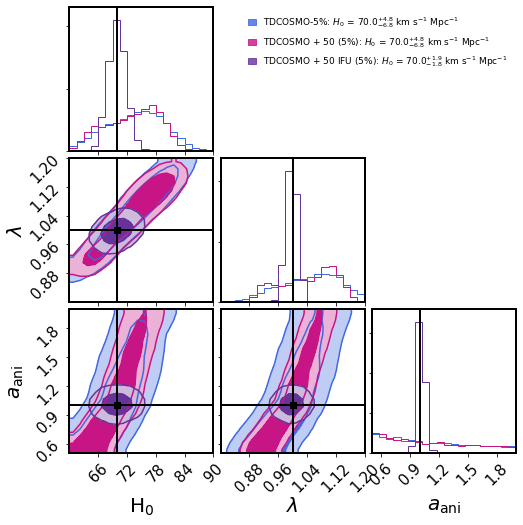

In [111]:

#truths = mcmc_sampler_tdcosmo_jwst.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_kin=kwargs_kin_true)
#labels=mcmc_sampler_tdcosmo_jwst.param_names(latex_style=True)

kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                 'levels': levels, 'truths': truths_select, 'truth_color': 'k',
                 'fill_contours': True, 'plot_datapoints': False,
                 'range': extents}

mcmc_samples_tdcosmo_aperture_select = select_params(mcmc_samples_tdcosmo_aperture, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_aperture_select,
                    labels=labels_select,
                    color=color_list[0],
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    contourf_kwargs={'color': color_list[0]},
                    **kwargs_corner
                   )

mcmc_samples_tdcosmo_aperture_ext_select = select_params(mcmc_samples_tdcosmo_aperture_ext, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_aperture_ext_select, color=color_list[2], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[2]}, **kwargs_corner)

mcmc_samples_tdcosmo_ifu_ext_select = select_params(mcmc_samples_tdcosmo_ifu_ext, param_indexes_select)
fig = corner.corner(mcmc_samples_tdcosmo_ifu_ext_select, color=color_list[3], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[3]}, **kwargs_corner)




ax = fig.axes[2]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_tdcosmo_aperture = plot_util.result_string(mcmc_samples_tdcosmo_aperture_ext[:,0]/np.median(mcmc_samples_tdcosmo_aperture_ext[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_ifu = plot_util.result_string(mcmc_samples_tdcosmo_ifu_ext[:,0]/np.median(mcmc_samples_tdcosmo_ifu_ext[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_tdcosmo_jwst = plot_util.result_string(mcmc_samples_tdcosmo_jwst_ext[:,0]/np.median(mcmc_samples_tdcosmo_jwst_ext[:,0])*70, weights=None, title_fmt=".1f", label=r'$H_0$')

patch_1 = mpatches.Patch(color=color_list[0], label='TDCOSMO-5%: ' + result_string_tdcosmo_aperture +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_2 = mpatches.Patch(color=color_list[2], label='TDCOSMO + 50 (5%): ' + result_string_tdcosmo_aperture +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_3 = mpatches.Patch(color=color_list[3], label='TDCOSMO + 50 IFU (5%): ' + result_string_tdcosmo_ifu +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)


ax.legend(handles=[patch_1, patch_2, patch_3], fontsize=9, handlelength=0.9, loc=1, frameon=False)
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/Forecast/tdcosmo_plus50_forecast.pdf')
fig.show()




In [63]:
# make table entries with percentages
# plot sharp at 70.0
fmt = "{{0:{0}}}".format(".1f").format

def percent_error(sample):
    return str(fmt(np.std(sample[:, 0])/np.mean(sample[:, 0])*100)) + '\% '

error_tdcosmo_aperture = percent_error(mcmc_samples_tdcosmo_aperture)
error_tdcosmo_ifu = percent_error(mcmc_samples_tdcosmo_ifu)
error_tdcosmo_aoifu = percent_error(mcmc_samples_tdcosmo_aoifu)
error_tdcosmo_jwst = percent_error(mcmc_samples_tdcosmo_jwst)
error_tdcosmo_elt = percent_error(mcmc_samples_tdcosmo_elt)

error_tdcosmo_aperture_ext = percent_error(mcmc_samples_tdcosmo_aperture_ext)
error_tdcosmo_ifu_ext = percent_error(mcmc_samples_tdcosmo_ifu_ext)
error_tdcosmo_aoifu_ext = percent_error(mcmc_samples_tdcosmo_aoifu_ext)
error_tdcosmo_jwst_ext = percent_error(mcmc_samples_tdcosmo_jwst_ext)
error_tdcosmo_elt_ext = percent_error(mcmc_samples_tdcosmo_elt_ext)

error_tdcosmo_aperture_ext_ifu = percent_error(mcmc_samples_tdcosmo_aperture_ext_ifu)
error_tdcosmo_ifu_ext_ifu = percent_error(mcmc_samples_tdcosmo_ifu_ext_ifu)
error_tdcosmo_aoifu_ext_ifu = percent_error(mcmc_samples_tdcosmo_aoifu_ext_ifu)
error_tdcosmo_jwst_ext_ifu = percent_error(mcmc_samples_tdcosmo_jwst_ext_ifu)
error_tdcosmo_elt_ext_ifu = percent_error(mcmc_samples_tdcosmo_elt_ext_ifu)


print(r'Scenario       & resolution & $\delta \sigma_*$  & FWHM & R$_{\rm spec}$/R$_{\rm eff}$ & N$_{\rm bin}$ & $\delta H_0$ & +50 $\delta H_0$ & +50IFU $\delta H_0$ \\ ')
print(r'\hline')
print(r'\hline')
print(r'TDCOSMO-5\%    & integrated & 5\%       & $0\farcs8$ & - & 1 &' + error_tdcosmo_aperture + ' & ' + error_tdcosmo_aperture_ext +  ' & ' + error_tdcosmo_aperture_ext_ifu +' \\\ ' )
print(r'TDCOSMO+O-IFU   & resolved   & 5\%       & $0\farcs8$ & 2 & 3 &  ' + error_tdcosmo_ifu + ' & ' + error_tdcosmo_ifu_ext + ' & ' + error_tdcosmo_ifu_ext_ifu +' \\\ ' )
print(r'TDCOSMO+AO-IFU  & resolved   & 5\%       & $0\farcs1$ & 1 & 10 &' + error_tdcosmo_aoifu + ' & ' + error_tdcosmo_aoifu_ext + ' & ' + error_tdcosmo_aoifu_ext_ifu +' \\\ ' )
print(r'TDCOSMO+JWST-IFU  & resolved   & 3\%       & $0\farcs1$ & 2 & 10 & ' + error_tdcosmo_jwst + ' & ' + error_tdcosmo_jwst_ext + ' & ' + error_tdcosmo_jwst_ext_ifu +' \\\ ' )
print(r'TDCOSMO+ELT-IFU  & resolved   & 3\%       & $0\farcs02$ & 3 & 30 & ' + error_tdcosmo_elt + ' & ' + error_tdcosmo_elt_ext + ' & ' + error_tdcosmo_elt_ext_ifu +' \\\ ' )


Scenario       & resolution & $\delta \sigma_*$  & FWHM & R$_{\rm spec}$/R$_{\rm eff}$ & N$_{\rm bin}$ & $\delta H_0$ & +50 $\delta H_0$ & +50IFU $\delta H_0$ \\ 
\hline
\hline
TDCOSMO-5\%    & integrated & 5\%       & $0\farcs8$ & - & 1 &8.2\%  & 7.5\%  & 2.6\%  \\ 
TDCOSMO+O-IFU   & resolved   & 5\%       & $0\farcs8$ & 2 & 3 &  4.5\%  & 2.6\%  & 2.6\%  \\ 
TDCOSMO+AO-IFU  & resolved   & 5\%       & $0\farcs1$ & 1 & 10 &4.6\%  & 2.6\%  & 2.6\%  \\ 
TDCOSMO+JWST-IFU  & resolved   & 3\%       & $0\farcs1$ & 2 & 10 & 3.4\%  & 2.6\%  & 2.6\%  \\ 
TDCOSMO+ELT-IFU  & resolved   & 3\%       & $0\farcs02$ & 3 & 30 & 3.3\%  & 2.6\%  & 2.5\%  \\ 


In [ ]:
# normalize to 70.0 sharp
# black ground truth
# add ELT mode